# Simulation / Monte Carlo

## Author(s), contact(s), and dates:
- Author: Nan Normann Jakobsen
- Email:  nnj@chem.ku.dk
- Date:   18th of January 2023 (latest update)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import sys
sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from scipy import stats
from scipy.integrate import quad, dblquad
from sympy import *

In [2]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

## Problem 3.1
### 3.1.1

In [3]:
runs = 10000

aims = np.random.normal(2.5, 1, size = runs)

scores = []
for aim in aims:
    if np.abs(aim) < 4:
        p_score = np.abs(aim) / 4
    else:
        p_score = 0
    scores.append(p_score)

scoring_chance = np.sum(scores) / len(scores)
print('Chance of scoring if you aim at x=2.5m:', scoring_chance)

Chance of scoring if you aim at x=2.5m: 0.5485127405367343


### 3.1.2

In [4]:
r = np.random
r.seed(42)
runs = 1000

In [5]:
aims = np.linspace(-4, 4, 50)
scoring_chance = []

for aim in aims:
    scores = []
    positions = r.normal(aim, 1, size = runs)
    for pos in positions:
        if np.abs(aim) < 4:
            p_score = np.abs(aim) / 4
        else:
            p_score = 0
        scores.append(p_score)

    chance = np.sum(scores) / len(scores)
    scoring_chance.append(chance)

print(max(scoring_chance))
print(aims[np.argmax(scoring_chance)])

0.959183673469388
-3.836734693877551


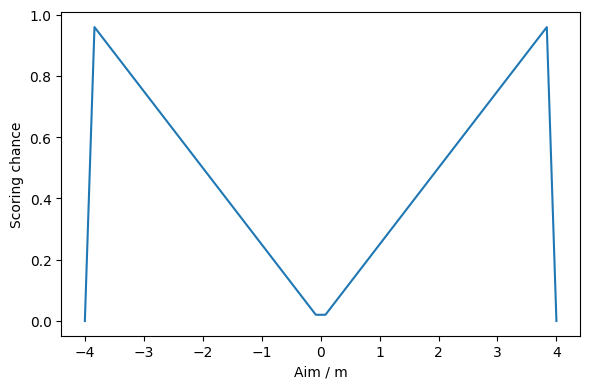

In [6]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(aims, scoring_chance)

ax.set(xlabel = 'Aim / m', ylabel = 'Scoring chance')

fig.tight_layout()
fig.savefig('scoring_chances.png', dpi = 200)

## Problem 3.2
### 3.2.1

In [7]:
def pdf_unnorm(x):
    return C * (atan(x) + np.pi / 2)

xmin, xmax = -3, 3

In [8]:
C, x = symbols('C, x')

I = integrate(pdf_unnorm(x), (x, xmin, xmax))
C_val = solve(I-1, C)

print(C_val)

[0.106103295394597]


In [9]:
# Test if PDF is normalized
def pdf(x):
    return C_val[0] * (np.arctan(x) + np.pi / 2)

result = quad(pdf, xmin, xmax)
if round(result[0], 5) == 1:
    print(result[0])
    print('PDF is normalized')
else:
    print(result[0])
    print('PDF is NOT normalized')

1.0
PDF is normalized


In [24]:
r = np.random
r.seed(42)

N_points = 100
ymin, ymax = pdf(xmin), pdf(xmax)
print(ymin,ymax)

x_gen = np.zeros(N_points)
Ntry = 0
for i in range(N_points):
    while True:
        Ntry += 1
        x2 = r.uniform(xmin, xmax)  
        y2 = r.uniform(ymin, ymax)        
        if (y2 < pdf(x2)) :   # If the (x,y)-point fulfills the accept condition...
            break      
    x_gen[i] = x2

0.0341387941165222 0.299194539216811


In [28]:
eff = N_points / Ntry                        # Efficiency of generating points (fraction accepted)
eff_error = np.sqrt(eff * (1-eff) / Ntry)    # Error on efficiency (binomial)
integral =  eff * (xmax-xmin) * ymax               # Integral
integral_error = eff_error * (xmax-xmin) * ymax    # Error on integral

print(f"Integral of f(x), x in [-3, 3] is: \t {integral:7.4f} +- {integral_error:6.4f}")
print(f"The efficiency of the accept/reject method is:  \t {eff:.2%} +/- {eff_error:.2%}")

Integral of f(x), x in [-3, 3] is: 	  0.9810 +- 0.0661
The efficiency of the accept/reject method is:  	 54.64% +/- 3.68%


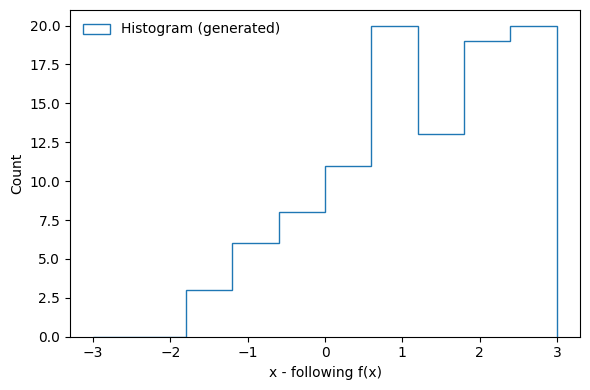

In [25]:
Nbins = int(len(x_gen) / 10)

fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(x_gen, bins=Nbins, range=(xmin, xmax), histtype='step', label='Histogram (generated)')

ax.set(xlabel='x - following f(x)', ylabel = 'Count')
ax.legend(frameon = False)

fig.tight_layout()
fig.savefig('random_gen.png', dpi = 200)

### 3.2.2

In [29]:
def pdf_fit(x, N, C):
    return N * C * (np.arctan(x) + np.pi / 2)

fit_object = UnbinnedLH(pdf_fit, x_gen, extended=True)
minuit = Minuit(fit_object, N=100, C=C_val[0])
minuit.errordef = 0.5
minuit.migrad()

c:\Users\nan25\OneDrive\Dokumenter\KU\5. år\AppStat\Exam\../External_Functions\ExternalFunctions.py:169: VisibleDeprecationWarning: make_func_code is deprecated: Use of `func_code` attribute to declare parameters is deprecated. Use `_parameters` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])
C:\Users\nan25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\iminuit\util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -218.9                     │              Nfcn = 25               │
│ EDM = 1.12e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │  0.10e3   │  0.17e3   │            │            │         │         │       │
│ 1 │ C    │   0.11    │   0.18    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        N        C │
├───┼───────────────────┤
│ N │ 2.74e+04  -29.015 │
│ C │  -29.015   0.0308 │
└───┴───────────────────┘

In [30]:
if (not minuit.fmin.is_valid) :                                   # Check if the fit converged!
    print("  WARNING: The unbinned likelihood fit DID NOT converge!!!")
minuit_output = [minuit.fmin, minuit.params]       # Save the output parameters in case needed
for name in minuit.parameters:
    print("  Unbinned LLH Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

  Unbinned LLH Fit result: N = 104.65201 +/- 165.53238
  Unbinned LLH Fit result: C = 0.11104 +/- 0.17564


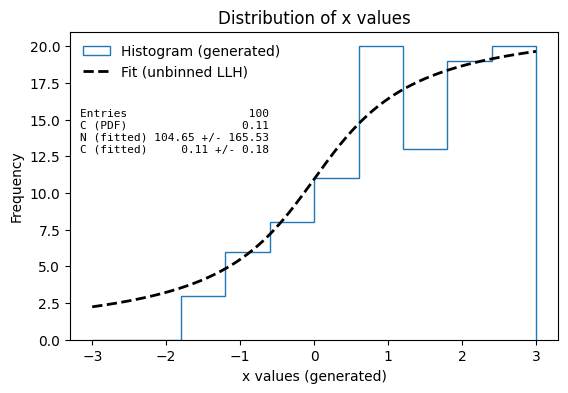

In [32]:
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(x_gen, bins=Nbins, range=(xmin, xmax), histtype='step', label='Histogram (generated)' )
# Plot fit result on top of histograms:
x_ulfit = np.linspace(xmin, xmax, 1000)                                    # Create the x-axis for the plot of the fitted function
y_ulfit = binwidth * pdf_fit(x_ulfit, *minuit.values)
ax.plot(x_ulfit, y_ulfit, '--', color='black', linewidth=2, label='Fit (unbinned LLH)')

ax.set(xlabel="x values (generated)", ylabel = "Frequency", title = "Distribution of x values")
ax.legend(frameon = False)

# Define figure text
d = {'Entries': len(x_gen),
     'C (PDF)': round(C_val[0], 2),
     'N (fitted)': [minuit.values[0], minuit.errors[0]],
     'C (fitted)': [minuit.values[1], minuit.errors[1]]
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=2)
add_text_to_ax(0.02, 0.75, text, ax, fontsize=8)

fig.savefig('random_gen_fitted.png', dpi = 200)